<a href="https://colab.research.google.com/github/mari967/simulacion_remiseria_tp6/blob/master/Cab_station_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabajo práctico 6
## Simulación para "Remises Delta" Nuñez



![100% real no fake](https://ichef.bbci.co.uk/news/410/cpsprodpb/F768/production/_112263336_taxi-mask.jpg)

## Introducción

Este es un cuaderno interactivo en el que es posible ejecutar código python en una máquina remota de Google

Pueden verse los resultados más recientes sin necesidad de ejecutar. Simplemente deslizarse por el cuaderno

Para ejecutar la simulación, ir a **Entorno de ejecución -> Ejecutar todo**

Todas las tablas y gráficos se actualizan con los nuevos valores obtenidos

En la parte superior izquierda se encuentra el índice con las distintas secciones del cuaderno (símbolo de tres líneas)

En la sección "Variables globales" es posible cambiar el valor de las variables de control 


### Variables 

>Datos | Control | Estado | Resultado 
> ---|---|---|---    
> FLLP | N | TC(i)|PTO
>KDV | CVD | CVUD(i)|PTE
>|||PDD 


#### Bibliotecas

In [0]:
from __future__ import print_function
from matplotlib import pyplot as plt
from IPython.display import display
import pandas as pd
import random
import math
import os

#### Variables Globales

In [0]:
cant_simulaciones = 100
TPP = 0
T = 0                                                     #Tiempo
TF = 2000                                                 #Tiempo final de la simulación
TV = 0

FLLP = []                                                  #Frecuencia de llegada de pedidos [Minutos]
KDV = 0                                                   #Kilómetros de viaje por cliente [Kilómetros]

CVD = 5                                                   #Cant. viajes entre desinfección
N = 10                                                    #Número de remiseros

TC = []                                                   #Tiempo comprometido de cada remisero
CVUD = []                                                 #Cant. viajes desde la última desinfección
NT = 0

TPD = []

PTOn = []
PTEn = []
PDDn = []
PTON = []
PTO = []                                                  #Porcentaje de tiempo ocioso de cada remisero (minutos)
PTE = []                                                  #Promedio de tiempo de espera de clientes en cada simulación (minutos)
PTET = []  # total
PDDD = []                                                 #Porcentaje de la ganancia destinado a desinfecciones
PTORN = []
STE = 0
STO = []

CLIENTES_PRIMER_SIMULACION = 0
se_arrepiente = False
GASTO = 0
GV = 0

valor_alcohol_en_gel_clie = 0.85
minutos_desinfeccion = 10
costo_desinfeccion = 200
precio_por_km = 33
porcentaje_ganancia_agencia = 0.2
km_por_hora = 22

## Simulación

Con el propósito de poder comparar los resultados entre las distintas simulaciones, se guarda la cantidad de clientes atendidos en la primer simulación, con el tiempo de llegada de cada uno en una lista.

Así, todas las simulaciones recibirán la misma cantidad de clientes en los mismo instantes T y el análisis del comportamiento del sistema será más objetivo.

La cantidad de clientes y sus instantes de llegada se actualiza en cada ejecución, por lo que distintas ejecuciones harán sus respectivas simulaciones con diferente catidad de clientes.

In [10]:
def generar_kdv(): return 11.323 * math.pow(math.pow(1 - random.random(), -1 / 0.70622) - 1, 1 / 2.6286)

def generar_fllp(): return 12.625 * math.pow(math.pow(1 - random.random(), -1 / 0.86891) - 1, 1 / 2.1342)

def llenar_listas():
    global TC, NT, STE, CVUD, STO, TPD
    for o in range(cant_simulaciones):
        PTOn.append(0)
        PTEn.append(0)
        PDDn.append(0)
    for z in range(N):
        TC.append(0)
        CVUD.append(0)
        STO.append(0)
        TPD.append(999999)
    return

def tpp_es_menor():
    global TPP, TPD, N
    respuesta = True
    for j in range(N):
        if TPP > TPD[j]:
            respuesta = False
    return respuesta

def buscar_menor_tc():
    pos = 0
    mini = TC[0]
    for k in range(N):
        if TC[k] < mini:
            mini = TC[k]
            pos = k
    return pos

def arrepentimiento(espera):
    if espera > 15:
        return random.random() > 0.5
    else:
        return False

def menor_tpd():
    indice = 0
    minimo = TPD[0]
    for d in range(N):
        if TPD[d] < minimo:
            minimo = TPD[d]
            indice = d
    TPD[indice] = 999999  # ################# al menor tpd le pongo HV
    return minimo

def vaciar_listas():
    global TPP, T, FLLP, KDV, TV, se_arrepiente, GASTO, GV, C, TC, NT, STE, CVUD, STO, TPD
    TPP = 0
    T = 0

    KDV = 0
    TV = 0
    se_arrepiente = False
    GASTO = 0
    GV = 0
    STE = 0
    NT = 0
    for i in range(N):
        PTORN[i] = 0
        TC[i] = 0
        CVUD[i] = 0
        STO[i] = 0
        TPD[i] = 999999
    return

def mostrar_resultados_remiseros_pto(cant_remiseros, lista_pto):
    print("\n\n________________________________________________________\n\n" + 
            "Simulación: N = " + str(N) + ", CVD = " + str(CVD) + 
            "\n________________________________________________________\n")
    remiseros = [i + 1 for i in range(cant_remiseros)]
    new_dataframe = { "Remisero" : remiseros,
                    "Porcentaje de tiempo ocioso del remisero": lista_pto 
                    }
    
    df = pd.DataFrame(new_dataframe, columns = ["Remisero", "Porcentaje de tiempo ocioso del remisero"])
    display(df)

def mostrar_resultados_pto_pte_pdd(pto, pte, pdd):
    print("\n\n")
    new_dataframe = { "Resultados":  ["Porcentaje de tiempo ocioso de los remiseros",
                                      "Promedio de tiempo de espera de los clientes", 
                                      "Porcentaje de dinero destinado a desinfección"],
                    "Valores": [pto, pte, pdd]
                    }
    df = pd.DataFrame(new_dataframe, columns = ["Resultados", "Valores"])
    display(df)

def simular(n, cvd, primer_simulacion):
    global TPP, T, FLLP, KDV, TV, se_arrepiente, GASTO, GV, TC, NT, STE, CVUD, STO, TPD, N, CVD, remiseros, CLIENTES_PRIMER_SIMULACION
    N = n
    CVD = cvd


    nro_cliente = 0
    while T < TF:
          if tpp_es_menor():
              T = TPP

              if(primer_simulacion):
                FLLP.append(generar_fllp())
                TPP = T + FLLP[-1]
                CLIENTES_PRIMER_SIMULACION += 1
              else:
                TPP = T + FLLP[nro_cliente]
                nro_cliente += 1
              
              i = buscar_menor_tc()
              KDV = generar_kdv()
              TV = (KDV * 60) / km_por_hora
              tiempo_de_espera = TC[i] - T
              se_arrepiente = arrepentimiento(tiempo_de_espera)
              if not se_arrepiente:
                  if T < TC[i]:  # ######### tiene que esperar
                      STE += TC[i] - T
                      TC[i] += 2*TV              ######## Por 2 porque el viaje es ida y vuelta
                  else:  # ################# lo lleva a tiempo
                      STO[i] += T - TC[i]  # sumo el tiempo ocioso
                      TC[i] = T + 2*TV          ######## Por 2 porque el viaje es ida y vuelta
                  if KDV <= 3:
                      GV += 3 * precio_por_km * porcentaje_ganancia_agencia
                  else:
                      GV += KDV * precio_por_km * porcentaje_ganancia_agencia
                  GASTO += valor_alcohol_en_gel_clie  # ######### alcohol en gel
                  CVUD[i] += 1
                  if CVUD[i] == CVD:  # #### en la proxima tiene que desinfectar
                      TPD[i] = TC[i]  # #### actualizo el tiempo de prox desinf
                      TC[i] += minutos_desinfeccion  # ####### y lo sumo al TC
                      CVUD[i] = 0
                      GASTO += costo_desinfeccion
                  NT += 1
                  

          else:  # ######################### es una desinfección
              T = menor_tpd()

    STOR = 0
    for k in range(N):
        if len(PTO) >= N:
            PTO[k] = (STO[k] * 100) / T
        else:
            PTO.append((STO[k] * 100) / T)

        STOR += PTO[k] # Promedio del pto de cada remis.
  
    pto = STOR / N
    pte = STE / NT
    pdd = GASTO * 100 / GV
    PTET.append(pte)                 # Se guardan resutados de todas las simulaciones
    PDDD.append(pdd)                 # Se usa para hacer los gráficos comparativos de simulaciones
    PTORN.append(pto)                

    mostrar_resultados_remiseros_pto(N, PTO)
    mostrar_resultados_pto_pte_pdd(pto, pte, pdd)

    vaciar_listas()


# MAIN
if __name__ == "__main__":
    llenar_listas()
    primer_simulacion = True
    for i in range(N):
        for j in range(CVD):
            simular(i + 1, j + 1, primer_simulacion)
            primer_simulacion = False



________________________________________________________

Simulación: N = 1, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.0


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.000000
1,Promedio de tiempo de espera de los clientes,1889.729627
2,Porcentaje de dinero destinado a desinfección,176.571058




________________________________________________________

Simulación: N = 1, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.0


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.000000
1,Promedio de tiempo de espera de los clientes,2051.899450
2,Porcentaje de dinero destinado a desinfección,83.506108




________________________________________________________

Simulación: N = 1, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.0


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.000000
1,Promedio de tiempo de espera de los clientes,1599.961490
2,Porcentaje de dinero destinado a desinfección,57.821226




________________________________________________________

Simulación: N = 1, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.0


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.000000
1,Promedio de tiempo de espera de los clientes,1787.713123
2,Porcentaje de dinero destinado a desinfección,35.141978




________________________________________________________

Simulación: N = 1, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.0


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.000000
1,Promedio de tiempo de espera de los clientes,3522.054667
2,Porcentaje de dinero destinado a desinfección,19.442036




________________________________________________________

Simulación: N = 2, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.215918


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.607959
1,Promedio de tiempo de espera de los clientes,833.092692
2,Porcentaje de dinero destinado a desinfección,116.406834




________________________________________________________

Simulación: N = 2, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.215918


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.607959
1,Promedio de tiempo de espera de los clientes,519.395057
2,Porcentaje de dinero destinado a desinfección,87.064202




________________________________________________________

Simulación: N = 2, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.215918


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.607959
1,Promedio de tiempo de espera de los clientes,371.938417
2,Porcentaje de dinero destinado a desinfección,60.247492




________________________________________________________

Simulación: N = 2, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.399112


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.699556
1,Promedio de tiempo de espera de los clientes,477.494957
2,Porcentaje de dinero destinado a desinfección,35.431203




________________________________________________________

Simulación: N = 2, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.215918


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,0.607959
1,Promedio de tiempo de espera de los clientes,476.631872
2,Porcentaje de dinero destinado a desinfección,31.279845




________________________________________________________

Simulación: N = 3, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,5.743822
2,3,6.718160


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,4.153994
1,Promedio de tiempo de espera de los clientes,61.244291
2,Porcentaje de dinero destinado a desinfección,157.463747




________________________________________________________

Simulación: N = 3, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.000000
1,2,1.215918
2,3,1.886152


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,1.034024
1,Promedio de tiempo de espera de los clientes,225.321946
2,Porcentaje de dinero destinado a desinfección,71.960700




________________________________________________________

Simulación: N = 3, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.066601
1,2,1.973528
2,3,2.609502


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,1.549877
1,Promedio de tiempo de espera de los clientes,736.142867
2,Porcentaje de dinero destinado a desinfección,41.887824




________________________________________________________

Simulación: N = 3, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,5.823113
1,2,10.109106
2,3,11.611551


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,9.181257
1,Promedio de tiempo de espera de los clientes,88.257234
2,Porcentaje de dinero destinado a desinfección,38.941295




________________________________________________________

Simulación: N = 3, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.408757
1,2,1.215918
2,3,1.886152


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,1.170276
1,Promedio de tiempo de espera de los clientes,187.252051
2,Porcentaje de dinero destinado a desinfección,26.614163




________________________________________________________

Simulación: N = 4, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.408757
1,2,11.475381
2,3,9.645890
3,4,5.910920


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,6.860237
1,Promedio de tiempo de espera de los clientes,24.143824
2,Porcentaje de dinero destinado a desinfección,175.993757




________________________________________________________

Simulación: N = 4, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,2.691230
1,2,4.727048
2,3,3.149329
3,4,3.851724


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,3.604833
1,Promedio de tiempo de espera de los clientes,58.962147
2,Porcentaje de dinero destinado a desinfección,51.046967




________________________________________________________

Simulación: N = 4, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,8.001362
1,2,14.180409
2,3,2.002515
3,4,4.832160


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,7.254112
1,Promedio de tiempo de espera de los clientes,40.524403
2,Porcentaje de dinero destinado a desinfección,34.695281




________________________________________________________

Simulación: N = 4, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,11.232296
1,2,8.847583
2,3,14.374106
3,4,12.058609


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,11.628149
1,Promedio de tiempo de espera de los clientes,136.615375
2,Porcentaje de dinero destinado a desinfección,32.539377




________________________________________________________

Simulación: N = 4, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,16.111328
1,2,14.924063
2,3,17.443619
3,4,18.265834


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,16.686211
1,Promedio de tiempo de espera de los clientes,65.574441
2,Porcentaje de dinero destinado a desinfección,30.653419




________________________________________________________

Simulación: N = 5, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,16.111328
1,2,17.759700
2,3,15.563453
3,4,4.069629
4,5,12.463693


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,13.193560
1,Promedio de tiempo de espera de los clientes,23.833375
2,Porcentaje de dinero destinado a desinfección,130.144617




________________________________________________________

Simulación: N = 5, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,7.950234
1,2,19.990480
2,3,14.982169
3,4,13.958980
4,5,14.436480


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,14.263669
1,Promedio de tiempo de espera de los clientes,18.011180
2,Porcentaje de dinero destinado a desinfección,78.375827




________________________________________________________

Simulación: N = 5, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,24.318380
1,2,20.013202
2,3,13.210131
3,4,19.305437
4,5,12.988706


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,17.967171
1,Promedio de tiempo de espera de los clientes,12.228938
2,Porcentaje de dinero destinado a desinfección,48.348095




________________________________________________________

Simulación: N = 5, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,15.861619
1,2,8.739351
2,3,7.748729
3,4,19.326130
4,5,11.156255


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,12.566417
1,Promedio de tiempo de espera de los clientes,22.184794
2,Porcentaje de dinero destinado a desinfección,33.482814




________________________________________________________

Simulación: N = 5, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.282871
1,2,10.319194
2,3,10.067529
3,4,13.024997
4,5,17.423053


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,10.223529
1,Promedio de tiempo de espera de los clientes,30.569540
2,Porcentaje de dinero destinado a desinfección,14.805902




________________________________________________________

Simulación: N = 6, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,0.282871
1,2,19.384959
2,3,26.763771
3,4,20.325039
4,5,21.809573
5,6,27.391277


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,19.326248
1,Promedio de tiempo de espera de los clientes,7.913877
2,Porcentaje de dinero destinado a desinfección,167.603174




________________________________________________________

Simulación: N = 6, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,16.724659
1,2,32.561511
2,3,29.944087
3,4,29.532727
4,5,25.666794
5,6,23.272232


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,26.283668
1,Promedio de tiempo de espera de los clientes,5.462834
2,Porcentaje de dinero destinado a desinfección,77.295498




________________________________________________________

Simulación: N = 6, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,21.978392
1,2,25.055347
2,3,18.649519
3,4,25.404676
4,5,20.999349
5,6,25.806986


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,22.982378
1,Promedio de tiempo de espera de los clientes,3.910242
2,Porcentaje de dinero destinado a desinfección,43.551535




________________________________________________________

Simulación: N = 6, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,28.816440
1,2,28.989146
2,3,26.119828
3,4,33.507647
4,5,15.263628
5,6,26.780761


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,26.579575
1,Promedio de tiempo de espera de los clientes,12.235141
2,Porcentaje de dinero destinado a desinfección,37.809696




________________________________________________________

Simulación: N = 6, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,21.625898
1,2,14.616325
2,3,8.362007
3,4,19.811081
4,5,16.953790
5,6,24.484632


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,17.642289
1,Promedio de tiempo de espera de los clientes,11.906254
2,Porcentaje de dinero destinado a desinfección,21.138105




________________________________________________________

Simulación: N = 7, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,21.625898
1,2,32.902591
2,3,35.175166
3,4,24.968909
4,5,31.205697
5,6,32.196661
6,7,12.358113


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,27.204719
1,Promedio de tiempo de espera de los clientes,6.698295
2,Porcentaje de dinero destinado a desinfección,159.418502




________________________________________________________

Simulación: N = 7, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,16.168007
1,2,7.698654
2,3,27.982523
3,4,29.957573
4,5,32.123260
5,6,25.883006
6,7,27.405276


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,23.888329
1,Promedio de tiempo de espera de los clientes,5.071875
2,Porcentaje de dinero destinado a desinfección,67.502114




________________________________________________________

Simulación: N = 7, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,30.869591
1,2,34.100930
2,3,37.568191
3,4,24.749339
4,5,38.874462
5,6,38.751351
6,7,36.077983


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,34.427406
1,Promedio de tiempo de espera de los clientes,1.216530
2,Porcentaje de dinero destinado a desinfección,47.992989




________________________________________________________

Simulación: N = 7, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,24.413549
1,2,24.445333
2,3,20.012761
3,4,24.348118
4,5,25.937359
5,6,27.331194
6,7,35.931779


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,26.060013
1,Promedio de tiempo de espera de los clientes,1.980548
2,Porcentaje de dinero destinado a desinfección,35.238684




________________________________________________________

Simulación: N = 7, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,26.992789
1,2,32.756811
2,3,29.410411
3,4,33.211573
4,5,34.923910
5,6,30.213219
6,7,22.486096


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,29.999259
1,Promedio de tiempo de espera de los clientes,10.235316
2,Porcentaje de dinero destinado a desinfección,25.875746




________________________________________________________

Simulación: N = 8, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,26.992789
1,2,35.505806
2,3,35.881471
3,4,39.637681
4,5,37.904188
5,6,28.226480
6,7,33.473264
7,8,46.312525


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,35.491776
1,Promedio de tiempo de espera de los clientes,1.015815
2,Porcentaje de dinero destinado a desinfección,178.282542




________________________________________________________

Simulación: N = 8, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,36.847775
1,2,15.423017
2,3,40.884565
3,4,30.885320
4,5,37.507760
5,6,39.487612
6,7,22.094183
7,8,28.525804


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,31.457005
1,Promedio de tiempo de espera de los clientes,1.826911
2,Porcentaje de dinero destinado a desinfección,72.855457




________________________________________________________

Simulación: N = 8, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,28.260525
1,2,29.675699
2,3,20.590116
3,4,33.616370
4,5,27.620117
5,6,6.100779
6,7,37.676703
7,8,28.423813


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,26.495515
1,Promedio de tiempo de espera de los clientes,1.545914
2,Porcentaje de dinero destinado a desinfección,38.516512




________________________________________________________

Simulación: N = 8, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,35.298608
1,2,31.409186
2,3,48.717123
3,4,25.325218
4,5,52.131664
5,6,40.371467
6,7,36.944652
7,8,42.927656


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,39.140697
1,Promedio de tiempo de espera de los clientes,0.270322
2,Porcentaje de dinero destinado a desinfección,40.802902




________________________________________________________

Simulación: N = 8, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,31.536128
1,2,37.539412
2,3,43.857500
3,4,38.929955
4,5,46.559124
5,6,32.633163
6,7,36.086212
7,8,39.745196


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,38.360836
1,Promedio de tiempo de espera de los clientes,0.480978
2,Porcentaje de dinero destinado a desinfección,28.265084




________________________________________________________

Simulación: N = 9, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,31.536128
1,2,47.406173
2,3,24.811561
3,4,40.812788
4,5,27.565655
5,6,33.247576
6,7,35.661429
7,8,38.987428
8,9,45.096728


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,36.125052
1,Promedio de tiempo de espera de los clientes,3.106149
2,Porcentaje de dinero destinado a desinfección,152.651535




________________________________________________________

Simulación: N = 9, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,32.841890
1,2,47.140274
2,3,19.390234
3,4,40.847188
4,5,42.051399
5,6,27.907370
6,7,33.647975
7,8,40.826238
8,9,29.644170


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,34.921860
1,Promedio de tiempo de espera de los clientes,1.069804
2,Porcentaje de dinero destinado a desinfección,66.274385




________________________________________________________

Simulación: N = 9, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,31.592615
1,2,39.414614
2,3,30.935124
3,4,35.941528
4,5,35.393423
5,6,43.671680
6,7,31.676170
7,8,43.686974
8,9,39.982490


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,36.921624
1,Promedio de tiempo de espera de los clientes,0.895741
2,Porcentaje de dinero destinado a desinfección,45.415541




________________________________________________________

Simulación: N = 9, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,44.879276
1,2,47.197438
2,3,46.332478
3,4,50.938355
4,5,57.699889
5,6,43.272911
6,7,48.904567
7,8,48.269318
8,9,47.411588


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,48.322869
1,Promedio de tiempo de espera de los clientes,0.000000
2,Porcentaje de dinero destinado a desinfección,40.816594




________________________________________________________

Simulación: N = 9, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,34.450696
1,2,31.155225
2,3,22.565480
3,4,40.845237
4,5,35.774992
5,6,49.415284
6,7,42.719688
7,8,47.212082
8,9,32.823896


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,37.440287
1,Promedio de tiempo de espera de los clientes,0.310075
2,Porcentaje de dinero destinado a desinfección,24.664546




________________________________________________________

Simulación: N = 10, CVD = 1
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,34.450696
1,2,47.561912
2,3,35.778459
3,4,27.689997
4,5,49.961442
5,6,34.649849
6,7,46.953861
7,8,49.995089
8,9,41.743475
9,10,46.205610


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,41.499039
1,Promedio de tiempo de espera de los clientes,0.447387
2,Porcentaje de dinero destinado a desinfección,160.336392




________________________________________________________

Simulación: N = 10, CVD = 2
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,57.579671
1,2,51.973469
2,3,29.459252
3,4,50.509296
4,5,49.809491
5,6,57.618842
6,7,40.635577
7,8,46.783645
8,9,40.102221
9,10,44.903586


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,46.937505
1,Promedio de tiempo de espera de los clientes,0.175585
2,Porcentaje de dinero destinado a desinfección,81.838609




________________________________________________________

Simulación: N = 10, CVD = 3
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,54.313428
1,2,43.840036
2,3,44.157655
3,4,27.514405
4,5,39.200089
5,6,52.138314
6,7,37.363501
7,8,53.122821
8,9,34.515797
9,10,45.324818


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,43.149086
1,Promedio de tiempo de espera de los clientes,0.369271
2,Porcentaje de dinero destinado a desinfección,41.854039




________________________________________________________

Simulación: N = 10, CVD = 4
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,46.045650
1,2,47.728767
2,3,53.836543
3,4,33.689050
4,5,36.375531
5,6,44.411863
6,7,42.896942
7,8,17.796462
8,9,30.811902
9,10,41.728485


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,39.53212
1,Promedio de tiempo de espera de los clientes,0.04654
2,Porcentaje de dinero destinado a desinfección,29.95809




________________________________________________________

Simulación: N = 10, CVD = 5
________________________________________________________



,Remisero,Porcentaje de tiempo ocioso del remisero
0,1,55.941710
1,2,48.963642
2,3,39.546036
3,4,34.526428
4,5,35.153216
5,6,17.414106
6,7,50.026545
7,8,46.831132
8,9,53.174747
9,10,41.749779


,Resultados,Valores
0,Porcentaje de tiempo ocioso de los remiseros,42.332734
1,Promedio de tiempo de espera de los clientes,0.402644
2,Porcentaje de dinero destinado a desinfección,23.326783


## Analisis de resultados

Todas las simulaciones recibieron la misma cantidad de clientes, que es:

In [11]:
CLIENTES_PRIMER_SIMULACION

101

El tiempo de duracion de cada simulación (en minutos) fue:

In [12]:
TF

2000

### Gráficos

Comparación de los resultados obtenidos en simulaciones con distintos valores de las variables de control 

(N = cantidad de remiseros y CVD = cantidad de viajes hasta la siguiente desinfección)

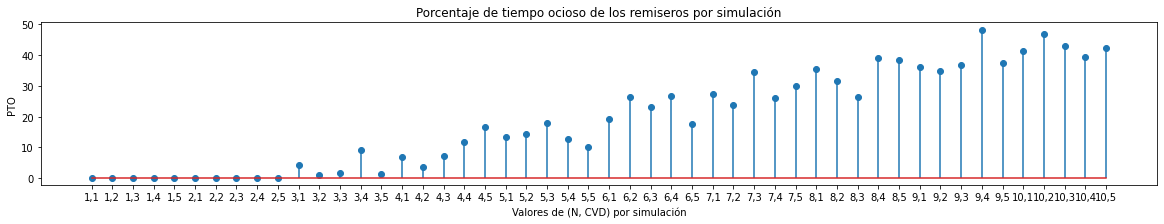

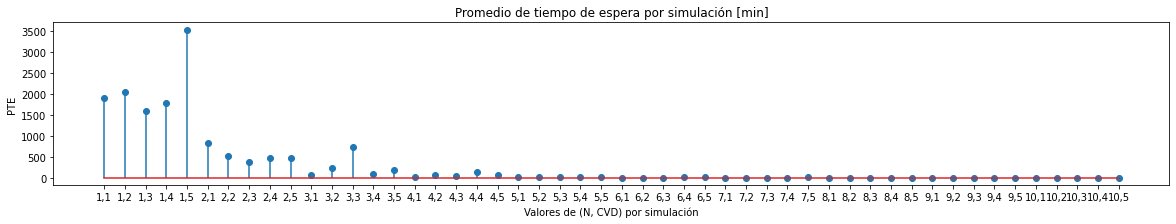

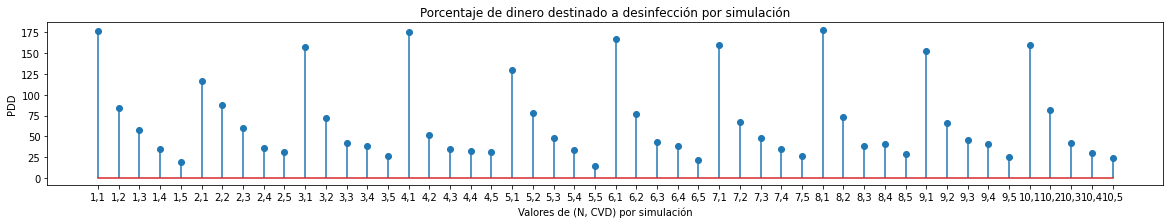

In [13]:
def graficar(listax, listay, titulo_graf, nombre_ejex, nombre_ejey):
    data = list(zip(listax,listay))
    labels, y = zip(*data)

    x = range(len(y))
    plt.rcParams["figure.figsize"] = (20, 3)
    plt.stem(x, y, use_line_collection=True)
    plt.xticks(x, labels)
    plt.xlabel(nombre_ejex)
    plt.ylabel(nombre_ejey)
    plt.title(titulo_graf)
    plt.show()

nro_simulacion = [str(i // CVD + 1) + "," + str(i % CVD + 1) for i in range(N * CVD)]

graficar(nro_simulacion, PTORN, "Porcentaje de tiempo ocioso de los remiseros por simulación", "Valores de (N, CVD) por simulación", "PTO")
graficar(nro_simulacion, PTET, "Promedio de tiempo de espera por simulación [min]", "Valores de (N, CVD) por simulación", "PTE")
graficar(nro_simulacion, PDDD, "Porcentaje de dinero destinado a desinfección por simulación", "Valores de (N, CVD) por simulación", "PDD")

### Tablas

Tablas de resultados con distintos valores de las variables de control

In [14]:
def mostrar_tabla_de_resultados(nombre, lista):
    cvds = [i + 1 for i in range(CVD)]
    print("")
    print("\n" + nombre)
    new_dataframe = { "CVD's" : cvds,
                    "N = 1": lista[0:5],
                    "N = 2": lista[5:10],
                    "N = 3": lista[10:15],
                    "N = 4": lista[15:20],
                    "N = 5": lista[20:25],
                    "N = 6": lista[25:30],
                    "N = 7": lista[30:35],
                    "N = 8": lista[35:40],
                    "N = 9": lista[40:45],
                    "N = 10": lista[45:50]
                    }
  
    df = pd.DataFrame(new_dataframe, columns = ["CVD's", "N = 1", "N = 2", "N = 3", "N = 4", "N = 5", "N = 6", "N = 7", "N = 8", "N = 9", "N = 10"])
    display(df)

mostrar_tabla_de_resultados("Porcentaje de Tiempo Ocioso", PTORN)
mostrar_tabla_de_resultados("Promedio de Tiempo de Espera [min]", PTET)
mostrar_tabla_de_resultados("Porcentaje de Ganancias para Desinfección", PDDD)



Porcentaje de Tiempo Ocioso


,CVD's,N = 1,N = 2,N = 3,N = 4,N = 5,N = 6,N = 7,N = 8,N = 9,N = 10
0,1,0,0,4.153994,6.860237,13.193560,19.326248,27.204719,35.491776,36.125052,41.499039
1,2,0,0,1.034024,3.604833,14.263669,26.283668,23.888329,31.457005,34.921860,46.937505
2,3,0,0,1.549877,7.254112,17.967171,22.982378,34.427406,26.495515,36.921624,43.149086
3,4,0,0,9.181257,11.628149,12.566417,26.579575,26.060013,39.140697,48.322869,39.532120
4,5,0,0,1.170276,16.686211,10.223529,17.642289,29.999259,38.360836,37.440287,42.332734




Promedio de Tiempo de Espera [min]


,CVD's,N = 1,N = 2,N = 3,N = 4,N = 5,N = 6,N = 7,N = 8,N = 9,N = 10
0,1,1889.729627,833.092692,61.244291,24.143824,23.833375,7.913877,6.698295,1.015815,3.106149,0.447387
1,2,2051.899450,519.395057,225.321946,58.962147,18.011180,5.462834,5.071875,1.826911,1.069804,0.175585
2,3,1599.961490,371.938417,736.142867,40.524403,12.228938,3.910242,1.216530,1.545914,0.895741,0.369271
3,4,1787.713123,477.494957,88.257234,136.615375,22.184794,12.235141,1.980548,0.270322,0.000000,0.046540
4,5,3522.054667,476.631872,187.252051,65.574441,30.569540,11.906254,10.235316,0.480978,0.310075,0.402644




Porcentaje de Ganancias para Desinfección


,CVD's,N = 1,N = 2,N = 3,N = 4,N = 5,N = 6,N = 7,N = 8,N = 9,N = 10
0,1,176.571058,116.406834,157.463747,175.993757,130.144617,167.603174,159.418502,178.282542,152.651535,160.336392
1,2,83.506108,87.064202,71.960700,51.046967,78.375827,77.295498,67.502114,72.855457,66.274385,81.838609
2,3,57.821226,60.247492,41.887824,34.695281,48.348095,43.551535,47.992989,38.516512,45.415541,41.854039
3,4,35.141978,35.431203,38.941295,32.539377,33.482814,37.809696,35.238684,40.802902,40.816594,29.958090
4,5,19.442036,31.279845,26.614163,30.653419,14.805902,21.138105,25.875746,28.265084,24.664546,23.326783
